In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Swaptionvol

# Import data from file and order it
datafile = pd.read_excel('Invertir_Smile_Mercado_Swaption.xlsx')
FS = datafile.iloc[22,2]
Premium_put = datafile.iloc[10,4:11].values/10000
Premium_call = datafile.iloc[10,11:17].values/10000
K_put = datafile.iloc[11,4:11].values;
K_call = datafile.iloc[11,11:17].values;
K = np.concatenate((np.hstack(K_put),np.hstack(K_call)),axis=None)
Annuity = datafile.iloc[20,2]; Expiry = datafile.iloc[5,4]
ATMstrike = K[np.nonzero(K == FS)]

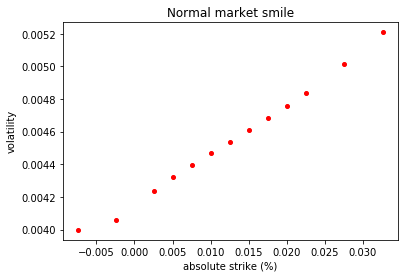

In [45]:
# Implied market Normal volatilies
sigmacall = []; sigmaput = [];
for i in range(K_call.size):
    sigmacall.append(Swaptionvol.SwaptionNormalvol(FS,K_call[i],Annuity,Expiry,Premium_call[i],1))
for j in range(K_put.size):
    sigmaput.append(Swaptionvol.SwaptionNormalvol(FS,K_put[j],Annuity,Expiry,Premium_put[j],-1))
sigmaMKT = np.asarray(sigmaput + sigmacall)
plt.plot(K,sigmaMKT,'ro',markersize=4); plt.title('Normal market smile');
plt.ylabel("volatility"); plt.xlabel("absolute strike (%)");

# Calibración por el primer método

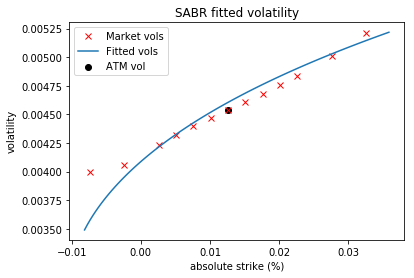

In [46]:
import SABRnormal
beta = 0.3; shift = 0.01
parametros = SABRnormal.calibrate(K,FS,Expiry, beta, shift, sigmaMKT)

alpha = parametros[0]; rho = parametros[1]; nu = parametros[2]; estvol = []

# representación de la parametrización
X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)

for i in range(len(X)):
    aux = SABRnormal.normal_vol(X[i],FS,Expiry,alpha,beta,rho,nu,shift)
    estvol.append(aux)
    
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT,'rx',label='Market vols')
plt.plot(X,estvol,label='Fitted vols')
plt.title('SABR fitted volatility'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.scatter(K[np.nonzero(K == FS)],sigmaMKT[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend();

# Calibración por el segundo método

Los parámetros estimados: [alpha, rho, nu] =  [0.016010703396829595, 0.5, 0.01]


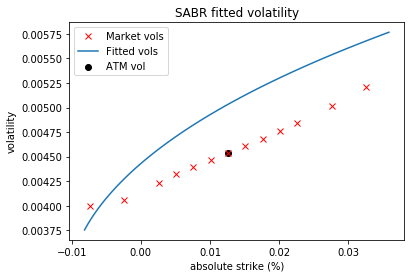

In [47]:
parametros = SABRnormal.calibrate2(K,FS,Expiry, beta, shift, sigmaMKT)

rho = parametros[0]; nu = parametros[1]; estvol = []

def alpha(rho,nu):
    coef1 = beta*(2-beta)*Expiry/(24*FS**(2-2*beta))
    coef2 = rho*beta*nu*Expiry/(4*FS**(1-beta))
    coef3 = 1 + (2 - 3 * rho * rho) * nu * nu * Expiry / 24
    coef4 = - sigmaMKT[np.nonzero(K == FS)] * FS ** (- beta)
    raices = np.roots([coef1,coef2,coef3,coef4])
    raices = raices[np.isreal(raices) == 1] #returns only real numbers
    raiz = np.amin(raices[raices>0])     #returns minimum positive value
    return raiz.real


# representación de la parametrización
X = np.arange(min(K)*1.1, max(K)*1.1, (max(K)-min(K))/100)

for i in range(len(X)):
    aux = SABRnormal.normal_vol(X[i],FS,Expiry,alpha(rho,nu),beta,rho,nu,shift)
    estvol.append(aux)
    
plt.figure()        #creates new figure
plt.plot(K,sigmaMKT,'rx',label='Market vols')
plt.plot(X,estvol,label='Fitted vols')
plt.title('SABR fitted volatility'); plt.ylabel('volatility'); plt.xlabel("absolute strike (%)");
plt.scatter(K[np.nonzero(K == FS)],sigmaMKT[np.nonzero(K == FS)],c="black",marker='o',label='ATM vol') #ATM
plt.legend(); print('Los parámetros estimados: [alpha, rho, nu] = ', [alpha(rho,nu), rho, nu])